 # Lab 10
 ### Name: Quentin Smith
 ### Due Date: April 7th, 2020

# 1. Overview

Given a dataset that describes monthly sea ice index, we want construct two univariate time-series models of monthly ice thickness in the Arctic. The models being used are ARIMA, SARIMAX, and Facebook's Prophet.

In [ ]:
import pandas as pd
import numpy as np


   



   

    


      
Resources:
1. Facebook Prophet - https://facebook.github.io/prophet/
2. ARIMA - https://people.duke.edu/~rnau/411arim.htm
3. ACF and PACF - http://people.duke.edu/~rnau/Slides_on_ARIMA_models--Robert_Nau.pdf
4. Residuals - https://otexts.com/fpp2/residuals.html
5. Seasonality - https://machinelearningmastery.com/time-series-seasonality-with-python/
6. Time Series Decomposition- https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/


# 2. Data

The data set describes a time series of Arctic and Antarctic sea ice thickness in meters. For our purposes, we will only be using the Arctic data thickness. Thickness is in meters. The data source is from https://timeseries.weebly.com/data-sets.html

In [ ]:
import pandas as pd 

#---- Data Preprocessing ----

#read data, drop Antarctica column, and look at datatypes
df = pd.read_csv('sea_ice.csv', parse_dates=[0], infer_datetime_format=True, usecols=['Time','Arctic'])
print(df.dtypes)

#Replace Column=Time M to -
df['Time'] = df['Time'].str.replace('M','-')


#Convert Column=Time to datetime for further data exploration
df['Time'] = pd.to_datetime(df['Time'])
df= df.set_index('Time')
df

Time       object
Arctic    float64
dtype: object


,Arctic
Time,
1990-01-01,12.72
1990-02-01,13.33
1990-03-01,13.44
1990-04-01,12.16
1990-05-01,10.84
...,...
2010-11-01,8.06
2010-12-01,10.02
2011-01-01,11.38


# 3.EDA

In [ ]:
df.describe()

,Arctic
count,255.000000
mean,9.362510
std,3.222151
min,2.780000
25%,6.365000
50%,10.100000
75%,12.320000
max,13.710000


## Time Chart with Decomposition of Time Series

A **Time Series** is a series of data points ordered in time. Time series decomposition involves thinking of that series as a combination of level, trend, seasonality, and noise components[6].

The **trend** component is supposed to capture the slowly-moving overall level of the series.

The **seasonal** component captures patterns that repeat every season.

The **residuals** component is what is left over after decomposing. It can be looked at the random variation in the series or noise[6].

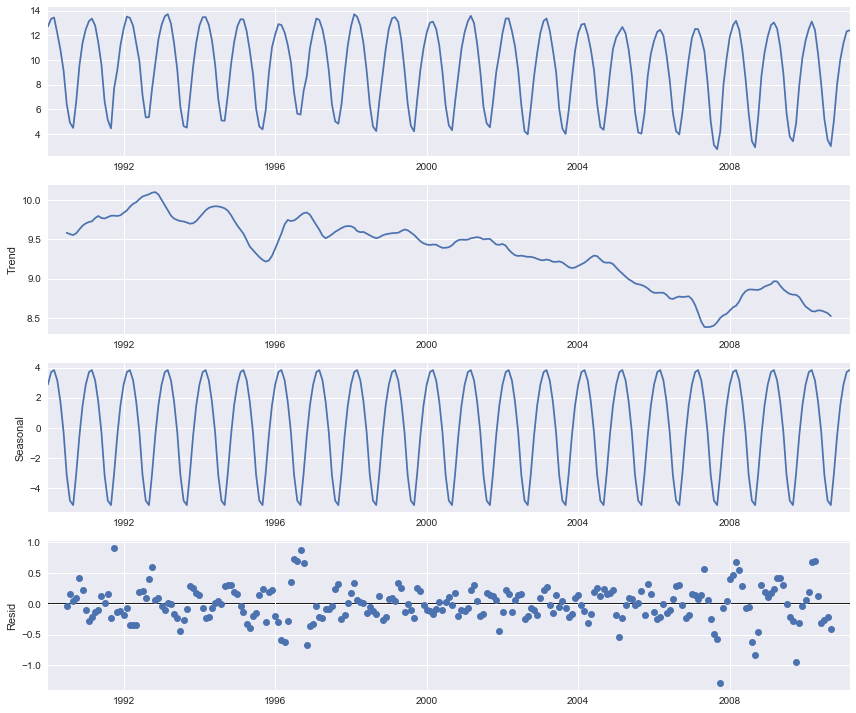

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn') 

from statsmodels.tsa.seasonal import seasonal_decompose

#change figsize
plt.rcParams['figure.figsize'] = (12,10)

#perform seasonal_decompose and plot the output graphs
result = seasonal_decompose(df, model='additive')
result.plot()
plt.show()

## ACF and PACF Charts

**ACF:** The autocorrelation function (ACF) plot shows the correlation of the series with itself at different lags [3]
    
**PACF:** The partial autocorrelation function (PACF) plot shows the amount of autocorrelation at lag k that is not explained by lower-order autocorrelations [3]

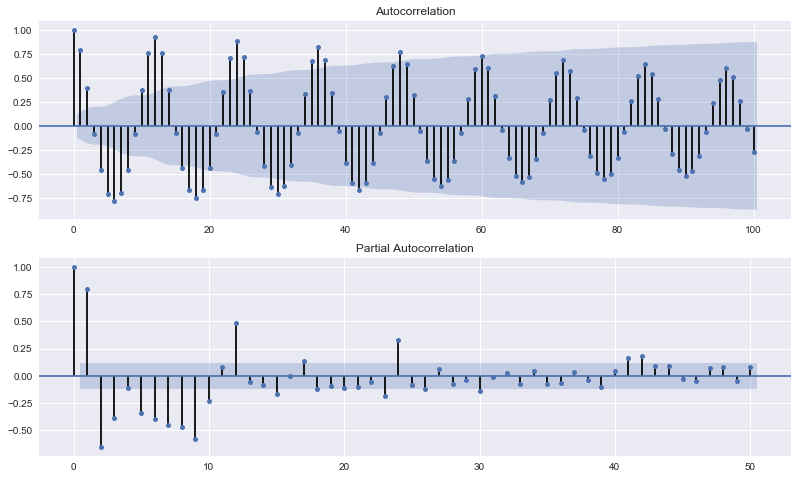

In [ ]:
#plot the ACF and PACF plots
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.diff().dropna(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.diff().dropna(), lags=50, ax=ax2)
plt.show()

## Models

Let's split the data set into train and test sets

In [ ]:
train, test = df.iloc[:241,0], df.iloc[240:,0]
print(train.head())

print('train size: ',train.shape)

print('\n', test.head())
print('\ntest size: ',test.shape)


Time
1990-01-01    12.72
1990-02-01    13.33
1990-03-01    13.44
1990-04-01    12.16
1990-05-01    10.84
Name: Arctic, dtype: float64
train size:  (241,)

 Time
2010-01-01    11.59
2010-02-01    12.52
2010-03-01    13.11
2010-04-01    12.43
2010-05-01    10.48
Name: Arctic, dtype: float64

test size:  (15,)


### ARIMA

The acronym **ARIMA** stands for Auto-Regressive Integrated Moving Average. ARIMA models are, in theory, the most general class of models for forecasting a time series which can be made to be “stationary” or have nonlinear transformation perfomed on it [2]. 

Let us perform ARIMA on the train and test set.

From the decompositional time series we see that the trend is going down which would indicate a d=1 and we can see there is seasonality in this data set so D=1. From the ACF plot we see that between lags 4 and 17 the data is within the thresholds so p= 4-17. From the PACF we see 13 lags are outside the thresholds so q= 0-13

Below we will run an auto-arima to find the lowest AIC score and highest BIC score from the parameters we described above:
- p = 4 - 17
- d = 1
- q = 0 - 13
- D = 1


### Sarimax Model:

 When running the auto_arima it picks the best model to use. SARIMAX was chosen. **SARIMAx** is sesasonal AutoRegressive Integrated Moving Average with eXogenous regressors model. Similar to ARIMA but adds in seasonality and eXogenous regressor model. 

In [ ]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")


Estimated differencing term: 0


The results from running KPSS and ADF to determine the differencing value is 0. This contradicts our previous prediction from the trend graph.

In [ ]:
#running auto-ARIMA using seasonal ARIMA model. 
import pmdarima as pm

model_best = pm.auto_arima(train, start_p=4, start_q=0,
              test='adf',
              max_p=17, max_q=13,
              m=1,
              d=1,
              seasonal=False,
              start_P=0,
              D=None,
              trace=True,
              error_action='ignore',
              suppress_warnings=True,
              stepwise=True)


print(model_best.summary())

#--------------
#defining variables for final comparison
aic_sarima = model_best.aic()
bic_sarima = model_best.bic()

Performing stepwise search to minimize aic
Fit ARIMA: (4, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=550.862, BIC=571.746, Time=0.109 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=945.314, BIC=952.275, Time=0.010 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=711.501, BIC=721.943, Time=0.050 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=764.904, BIC=775.346, Time=0.049 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=943.316, BIC=946.796, Time=0.008 seconds
Fit ARIMA: (3, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=551.679, BIC=569.082, Time=0.075 seconds
Fit ARIMA: (5, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=524.940, BIC=549.304, Time=0.153 seconds
Fit ARIMA: (6, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=482.766, BIC=510.611, Time=0.228 seconds
Fit ARIMA: (7, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=429.996, BIC=461.322, Time=0.506 seconds
Near non-invertible roots for order (7, 1, 0)(0, 0, 0, 0); setting score to inf (at least on

In [ ]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

def forecast_one_step():
    fc, conf_int = model_best.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model_best.update(new_ob)

#--------------
#defining variables for final comparison

mse_sarima =  mean_squared_error(test, forecasts)  
smape_sarima = smape(test, forecasts)

print("Mean squared error: ", mse_sarima)
print("SMAPE: ", smape_sarima)
print('AIC: ', aic_sarima)
print('BIC: ', bic_sarima)

Mean squared error:  0.5776528871116493
SMAPE:  9.072865529817683
AIC:  163.26271623482063
BIC:  211.9916611616085


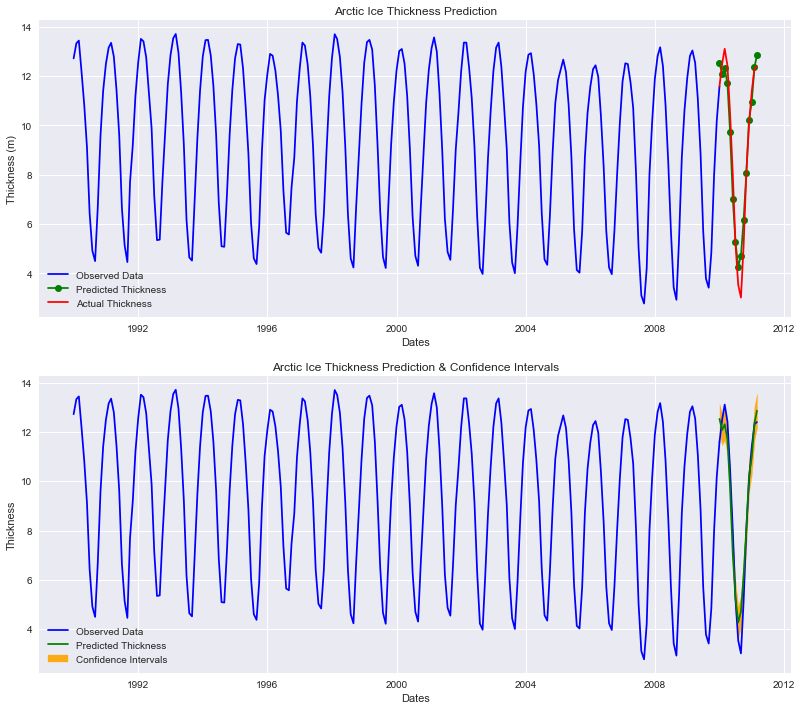

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------

axes[0].plot(train, color='blue', label='Observed Data')
# axes[0].plot(test, color ='blue')
axes[0].plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Thickness')

axes[0].plot(test.index, test, color='red', label='Actual Thickness')

axes[0].set_title('Arctic Ice Thickness Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Thickness (m)')

axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(train, color='blue', label='Observed Data')
axes[1].plot(test, color ='blue')
axes[1].plot(test.index, forecasts, color='green',
             label='Predicted Thickness')

axes[1].set_title('Arctic Ice Thickness Prediction & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Thickness')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].legend()

plt.show()

### ARIMA model

We will use the same (p,d,q) found from the SARIMAX model.

In [ ]:
# Putting found (p,d,q) into ARIMA model. Above is the seassonal ARIMA model. 

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, order=(12,1,0))
model_fit = model.fit()

print(model_fit.summary())

C:\Users\hv2486co\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hv2486co\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hv2486co\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:               D.Arctic   No. Observations:                  240
Model:                ARIMA(12, 1, 0)   Log Likelihood                 -75.565
Method:                       css-mle   S.D. of innovations              0.308
Date:                Tue, 07 Apr 2020   AIC                            179.130
Time:                        14:18:13   BIC                            227.859
Sample:                    02-01-1990   HQIC                           198.764
                         - 01-01-2010                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0033   2.69e-09  -1.23e+06      0.000      -0.003      -0.003
ar.L1.D.Arctic     -0.1922        nan        nan        nan         nan         nan
ar.L2.D.Arctic     -0.2784    4.

C:\Users\hv2486co\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


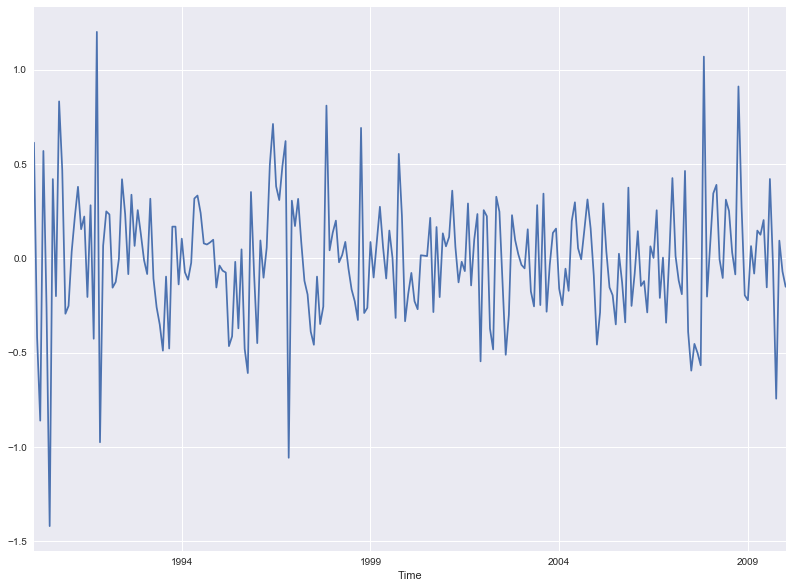

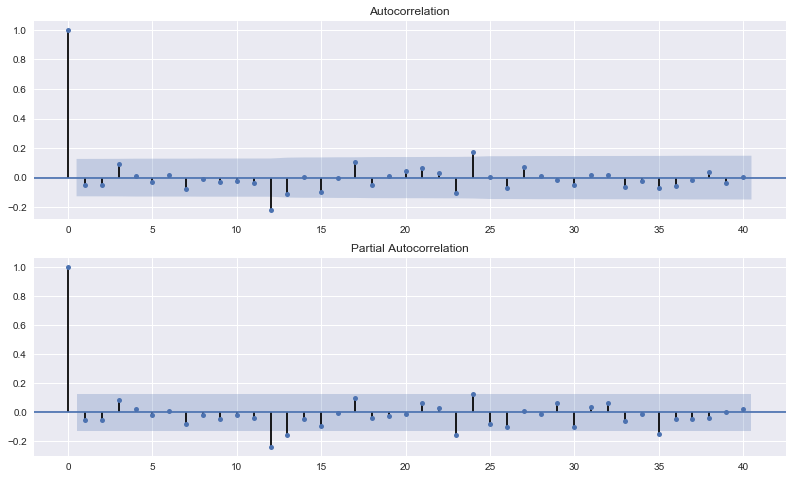

In [ ]:
#---- Graph residuals ----

model_fit.resid.plot()
plt.show()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(model_fit.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(model_fit.resid, lags=40, ax=ax2)
plt.show()

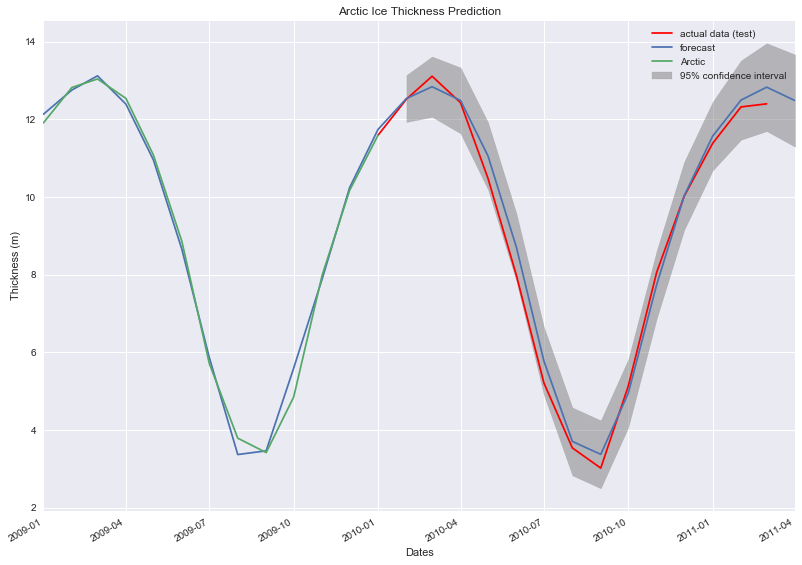

In [ ]:
#------ Graph forecast vs actual w confidence interval ------

fig, ax = plt.subplots()
#ax = test.plot(ax=ax)
ax.plot(test, color= 'red', label='actual data (test)')
fig = model_fit.plot_predict('2009-1-1', 255, ax=ax)

ax.set_title('Arctic Ice Thickness Prediction')
ax.set_xlabel('Dates')
ax.set_ylabel('Thickness (m)')

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

#------ summary statistics of actual vs predicted ---------

forecast = model_fit.predict(start=1, end=15) #length of test set
mse_arima =  mean_squared_error(test, forecast)  
smape_arima = smape(test, forecast)
aic_arima = model_fit.aic
bic_arima = model_fit.bic
print('AIC: ', aic_arima)
print('BIC: ', bic_arima)


print("Mean squared error: ", mse_arima)
print("SMAPE: ", smape_arima)

AIC:  179.13005892910928
BIC:  227.85900385589716
Mean squared error:  101.7494881824122
SMAPE:  172.06002236733005


### FB Prophet

**FB Prophet:** Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects [1].

Note: FB prophet needs to use ds and y for respective column names Time and Arctic. Need to redo data preprocessing. 

In [ ]:
# From: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3
import pandas as pd
import numpy as np
from fbprophet import Prophet

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
#Redo data preprocessing
df = pd.read_csv('sea_ice.csv')

df.head(5)

,Time,Arctic,Antarctica
0,1990M01,12.72,3.27
1,1990M02,13.33,2.15
2,1990M03,13.44,2.71
3,1990M04,12.16,5.10
4,1990M05,10.84,7.37


In [ ]:
#------ check data type

df = pd.read_csv('sea_ice.csv', parse_dates=[0], infer_datetime_format=True, usecols=['Time','Arctic'])
print(df.dtypes)

#------- Replace Column=Time M to -

df['Time'] = df['Time'].str.replace('M','-')
df.head(5)


Time       object
Arctic    float64
dtype: object


,Time,Arctic
0,1990-01,12.72
1,1990-02,13.33
2,1990-03,13.44
3,1990-04,12.16
4,1990-05,10.84


In [ ]:
#------- change to datetime ---------

df['Time'] = pd.DatetimeIndex(df['Time'])
print(df.dtypes)
df.head(5)

Time      datetime64[ns]
Arctic           float64
dtype: object


,Time,Arctic
0,1990-01-01,12.72
1,1990-02-01,13.33
2,1990-03-01,13.44
3,1990-04-01,12.16
4,1990-05-01,10.84


In [ ]:
#------ Split into train and test sets ----

test = df.iloc[240:]
train = df.iloc[:241]  
print(train.head(5))
print(test.head(5))

        Time  Arctic
0 1990-01-01   12.72
1 1990-02-01   13.33
2 1990-03-01   13.44
3 1990-04-01   12.16
4 1990-05-01   10.84
          Time  Arctic
240 2010-01-01   11.59
241 2010-02-01   12.52
242 2010-03-01   13.11
243 2010-04-01   12.43
244 2010-05-01   10.48


In [ ]:
#------ Change column names to match FB prophet requirements -------
train = train.rename(columns={'Time': 'ds',
                        'Arctic': 'y'})

train.head(5)

,ds,y
0,1990-01-01,12.72
1,1990-02-01,13.33
2,1990-03-01,13.44
3,1990-04-01,12.16
4,1990-05-01,10.84


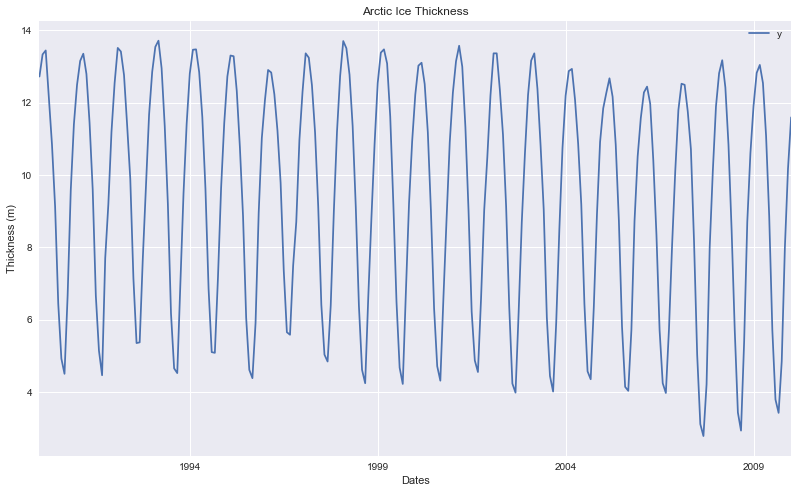

In [ ]:
#------ graph of data -----
pd.plotting.register_matplotlib_converters() #fix: float() argument must be a string or a number, not 'Period'
ax = train.set_index('ds').plot(figsize=(12, 8))

ax.set_title('Arctic Ice Thickness')
ax.set_xlabel('Dates')
ax.set_ylabel('Thickness (m)')

plt.show()


In [ ]:
#------ set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95)

In [ ]:
my_model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future_dates = my_model.make_future_dataframe(periods=15, freq='MS')
future_dates.tail()

,ds
251,2010-12-01
252,2011-01-01
253,2011-02-01
254,2011-03-01
255,2011-04-01


In [ ]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
251,2010-12-01,9.983743,9.300761,10.672902
252,2011-01-01,11.369742,10.701346,11.971249
253,2011-02-01,12.158952,11.464343,12.826320
254,2011-03-01,12.280081,11.661712,12.963392
255,2011-04-01,11.557188,10.902957,12.176983


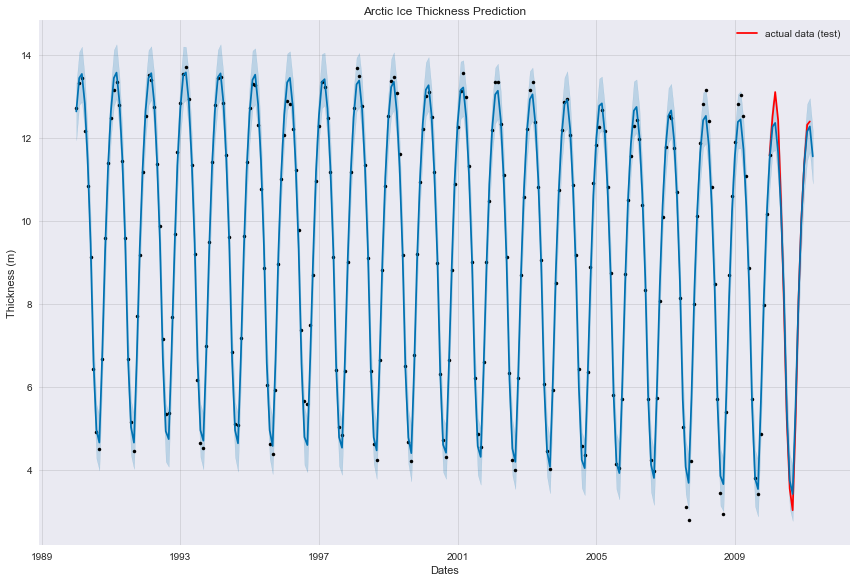

In [ ]:
#------ Graph actual data vs forecasts data with confidence intervals ------

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test.set_index('Time'), color= 'red', label='actual data (test)')
fig= my_model.plot(forecast, uncertainty=True, ax=ax)

ax.set_title('Arctic Ice Thickness Prediction')
ax.set_xlabel('Dates')
ax.set_ylabel('Thickness (m)')

ax.legend()

Figure(648x432)


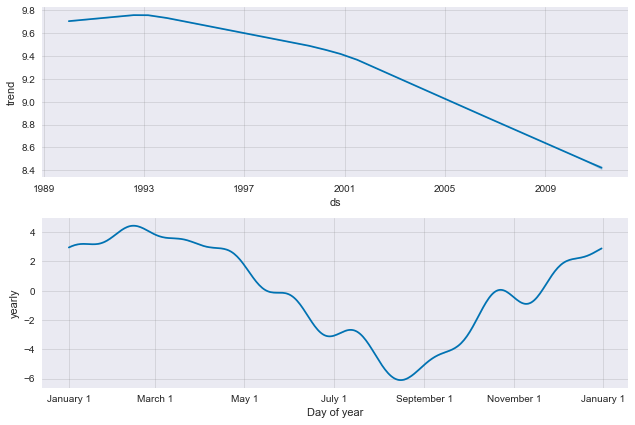

In [ ]:
print(my_model.plot_components(forecast))

In [ ]:
from sklearn.metrics import mean_squared_error

#----- create new dataframe with metrics ------

metric_df= forecast.set_index('ds')[['yhat']].join(df.set_index('Time')).reset_index()
print(metric_df.tail(5))
metric_df.dropna(inplace=True)
print(metric_df.tail(5))

            ds       yhat  Arctic
251 2010-12-01   9.983743   10.02
252 2011-01-01  11.369742   11.38
253 2011-02-01  12.158952   12.32
254 2011-03-01  12.280081   12.40
255 2011-04-01  11.557188     NaN
            ds       yhat  Arctic
250 2010-11-01   8.036484    8.06
251 2010-12-01   9.983743   10.02
252 2011-01-01  11.369742   11.38
253 2011-02-01  12.158952   12.32
254 2011-03-01  12.280081   12.40


In [ ]:
from sklearn.metrics import mean_squared_error

#---- calculation for MSE -----
mse_prophet = mean_squared_error(metric_df.Arctic, metric_df.yhat)


#---- Calculation for SMAPE-----
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

A = metric_df.Arctic
F = metric_df.yhat
smape_prophet = smape(A, F)

#---- Calculation for AIC and BIC
y= metric_df.Arctic
y_hat = metric_df.yhat
resid = y - y_hat
sse = sum(resid**2)
k = 1
aic_prophet= 2*k - 2*np.log(sse)

k = 1
n = len(y_hat)
bic_prophet = n*np.log(sse/n) + k*np.log(n)

print('AIC: ', aic_prophet)
print('BIC: ', bic_prophet)
print("Mean squared error: ", mse_prophet)
print("SMAPE: ", smape_prophet)

AIC:  -4.757941477273915
BIC:  -545.843402117816
Mean squared error:  0.11506100574679208
SMAPE:  3.400806231927495


# 4.) Summary

Given the dataset for monthly sea ice index, we constructed three univariate time-series models of monthly ice thickness in the Arctic. The models used were ARIMA, SARIMAX, and Facebook's Prophet.

Using the models to predict for 1/2010 and later with a graphic to compare actuals vs. predictions provides a quick glance to how close the prediction was to the actual. We can see from all graphs that the predicted is within the 95% confidence interval and is very similar to our actual test set values. When all models look close it is difficult to choose which model is the preferred method. That is why we use different criterion for method selection. 

## Comparing the Models

The different criterion used for method selection are AIC, BIC, MSE, and SMAPE.

**Akaike Information Criterion (AIC)** is an estimator of out-of-sample prediction error and thereby relative quality of statistical models for a given set of data. The lower the AIC the closer the out-of-sample prediction is to the actual data. 

**Bayesian Information Criterion (BIC)** is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred. The BIC is based on the likelihood function. 
 
**Mean Squared Error (MSE)** the average squared difference between the estimated values and the actual value. The model with the lowest MSE is preferred. 
  
**Symmetric Mean Absolute Percentage Error (SMAPE or sMAPE)** is an accuracy measure based on percentage (or relative) errors. The lower the SMAPE output the more preffered the model is. 

In [ ]:
results = [(aic_sarima, bic_sarima, mse_sarima, smape_sarima), 
          (aic_arima, bic_arima, mse_arima, smape_arima),
          (aic_prophet, bic_prophet, mse_prophet, smape_prophet)]


compare_df = pd.DataFrame(results, columns = ['AIC' , 'BIC', 'Mean Squared Error', 'SMAPE'],
                          index=['SARIMAX', 'ARIMA', 'FB PROPHET'])
compare_df

,AIC,BIC,Mean Squared Error,SMAPE
SARIMAX,163.262716,211.991661,0.577653,9.072866
ARIMA,179.130059,227.859004,101.749488,172.060022
FB PROPHET,-4.757941,-545.843402,0.115061,3.400806


In [ ]:
#-------return model name------------
def ret_index_name(x):
  if x == (aic_sarima or bic_sarima or mse_sarima or smape_sarima):
        return 'SARIMA'
  elif x == (aic_arima or bic_arima or mse_arima or smape_arima):
        return 'ARIMA'
  else:
        return 'Prophet'

#---- return min of test-----
min_aic = (min(aic_sarima, aic_arima, aic_prophet))
min_bic = (min(bic_sarima, bic_arima, bic_prophet))
min_mse = (min(mse_sarima, mse_arima, mse_prophet))
min_smape = (min(smape_sarima, smape_arima, smape_prophet))


print('The lowest AIC score is ', ret_index_name(min_aic))
print('The lowest BIC score is ', ret_index_name(min_bic))
print('The lowest MSE score is ', ret_index_name(min_mse))
print('The lowest SMAPE score is', ret_index_name(min_smape))

The lowest AIC score is  Prophet
The lowest BIC score is  Prophet
The lowest MSE score is  Prophet
The lowest SMAPE score is Prophet


## Conclusion

The three models were easy to implement with Facebook's prophet needing more specific requirements during preprocessing. 

All methods show the preferred model to use is Facebook's Prophet.

While looking at the trend model for the forecast of FB Prophet we see that the there is a clear downward trend that the ice is thinning. 

### Further Research
While the clear prefferred model is Facebook's prophet I believe with parameter tuning we can lower the other two models, ARIMA and SARIMAX, score closer to that of Facebook's model. 
